# Часть 2: Тест Вензингера
## Двумерный многозвенный профиль

In [40]:
import os
import pandas as pd
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
import itertools

%matplotlib inline

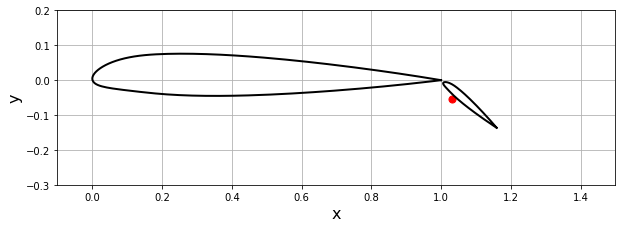

In [41]:
NumberOfPanels = 150 # количество панелей
x_rotation = 1.03
y_rotation = -0.054
angle_rotation = 40.0*math.pi/180

## геометрия главной части
naca_main_filepath = os.path.join('resources', 'NACA23012_MainFoil.csv')
main_coord = pd.read_csv(naca_main_filepath, names=('x', 'y'))
x_main = main_coord.x.values
y_main = main_coord.y.values

## геометрия закрылки 
naca_flap_filepath = os.path.join('resources', 'NACA23012_FlapFoil.csv')
flap_coord = pd.read_csv(naca_flap_filepath, names=('x', 'y'))
x_const = flap_coord.x.values
y_const = flap_coord.y.values


x_flap = x_rotation + (x_const-x_rotation)*math.cos(angle_rotation) + (y_const - y_rotation)*math.sin(angle_rotation)
y_flap = y_rotation - (x_const-x_rotation)*math.sin(angle_rotation) + (y_const - y_rotation)*math.cos(angle_rotation)

## визуализация 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2)

pyplot.scatter(x_rotation,y_rotation, s = 50, color = "red")
pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2);

In [42]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления
        self.gamma = 0.0 # циркуляция

In [43]:
def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [44]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [45]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [46]:
def source_contribution_normal(panels_first, panels_second):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size), dtype=float)
    
    # вклад рассматриваемой панели в общее поле источников
    numpy.fill_diagonal(A, 0.5)
    # вклад остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [47]:
def vortex_contribution_normal(panels_first, panels_second):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size), dtype=float)
    
    # вклад от рассматриваемой панели в поле вихря
    numpy.fill_diagonal(A, 0.0)
    # вихревой вклад от всех остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [48]:
def kutta_condition(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the Kutta condition array.
    """
    Na = NumberOfPanels
    b = numpy.empty((2, A_source.shape[0] + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    
    
    b[0,:-2] = B_vortex[0, :] + B_vortex[Na-1, :]
    b[1,:-2] = B_vortex[Na, :] + B_vortex[-1, :]
    
    b[0,-2] = - numpy.sum(A_source[0, :Na] + A_source[Na-1, :Na])
    b[0,-1] = - numpy.sum(A_source[0, Na:] + A_source[Na-1, Na:])
    
    b[1,-2] = - numpy.sum(A_source[Na, :Na] + A_source[-1, :Na])
    b[1,-1] = - numpy.sum(A_source[Na, Na:] + A_source[-1, Na:])
    
    return b

In [49]:
def build_singularity_matrix(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    Na = NumberOfPanels
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
                    
    # матрица источников
    A[:-2, :-2] = A_source
    
    # матрица вихрей
    A[:-2,-2] = numpy.sum(B_vortex[:,:Na], axis=1).transpose() 
    A[:-2,-1] = numpy.sum(B_vortex[:,Na:], axis=1)
    
    # условие Кутты-Жуковского
    A[-2:, :] = kutta_condition(A_source, B_vortex) #последние 2 строки матрицы
    return A

In [50]:
def build_freestream_rhs(panels_first, panels_second, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels_first.size + panels_second.size + 2,dtype=float)
    # вклад от набегающего потока в каждую панель
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
        
    # вклад от набегающего потока в условии Кутты-Жуковского
    b[-2] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels_first[0].beta)
                               +numpy.sin(freestream.alpha-panels_first[-1].beta))
    b[-1] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels_second[0].beta)
                               +numpy.sin(freestream.alpha-panels_second[-1].beta))
    return b

### Коэффициент давления на поверхности 

In [51]:
def compute_tangential_velocity(panels_first,panels_second, freestream, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    
    ## вклад основной части
    A[:, -2] = -numpy.sum(A_source[:,:panels_first.size], axis=1)
    ## вклад закрылки 
    A[:, -1] = -numpy.sum(A_source[:,panels_first.size:], axis=1)
    
    # добавляем набегающий поток
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in itertools.chain(panels_first,panels_second)])
    
    ## достаем гаммы из каждой панели
    strengths = numpy.empty( (panels_first.size + panels_second.size+2,),dtype=float)
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        strengths[i] = panel.sigma
    strengths[-2] = panels_first[0].gamma
    strengths[-1] = panels_second[0].gamma
    
    ## вычисляем тангенцальную компоненту
    tangential_velocities = numpy.dot(A, strengths) + b
    
    ## каждой панели раскидываем скорости
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        panel.vt = tangential_velocities[i]
        

In [52]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

## Вопрос 1

Используйте метод деления отрезка пополам для определения угла атаки $\alpha$, при котором подъемная сила равна нулю при отклонении закрылка $20$º. Округлите ответ до второго знака после плавающей точки.
Подсказка: можно начать поиск в интервале $-14\le\alpha\le14$.

In [56]:
NumberOfPanels = 150 # количество панелей
x_rotation = 1.03
y_rotation = -0.054
angle_rotation = 20.0*math.pi/180 

## геометрия главной части
naca_main_filepath = os.path.join('resources', 'NACA23012_MainFoil.csv')
main_coord = pd.read_csv(naca_main_filepath, names=('x', 'y'))
x_main = main_coord.x.values
y_main = main_coord.y.values

## геометрия закрылки 
naca_flap_filepath = os.path.join('resources', 'NACA23012_FlapFoil.csv')
flap_coord = pd.read_csv(naca_flap_filepath, names=('x', 'y'))
x_const = flap_coord.x.values
y_const = flap_coord.y.values


x_flap = x_rotation + (x_const-x_rotation)*math.cos(angle_rotation) + (y_const - y_rotation)*math.sin(angle_rotation)
y_flap = y_rotation - (x_const-x_rotation)*math.sin(angle_rotation) + (y_const - y_rotation)*math.cos(angle_rotation)


In [57]:
## расчет геометрии в панели
panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)

## критические значения угла атаки в градусах 
angle_freestreem_a = -14.0
angle_freestreem_b = 14.0

while abs(angle_freestreem_a - angle_freestreem_b) > 1e-2:
    
    ## параметры набегающего потока
    freestream = Freestream(u_inf=1.0, alpha=(angle_freestreem_a +angle_freestreem_b)/2)
    
    ## расчет параметров панелей
    ###################################################
    A_source = source_contribution_normal(panels_main, panels_flap)
    B_vortex = vortex_contribution_normal(panels_main, panels_flap)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels_main, panels_flap, freestream)
    
    strengths = numpy.linalg.solve(A, b)
    
    for i , panel in enumerate(panels_main):
        panel.sigma = strengths[i]
        panel.gamma = strengths[-2]
    for i , panel in enumerate(panels_flap):
        panel.sigma = strengths[i+panels_flap.size]
        panel.gamma = strengths[-1]
    
    compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
    compute_pressure_coefficient(panels_main, freestream)
    compute_pressure_coefficient(panels_flap, freestream)
    ######################################################
    

    ## хорды
    c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
    c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

    ## коэф подъемной силы
    cl_new = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
           panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / (0.5*freestream.u_inf*(c_main + c_flap))
    print("cl = {:.4f}. угол отклонения закрылка = {:.4f}".format(cl_new,
                                                                    (angle_freestreem_a + angle_freestreem_b)/2))
    if cl_new > 0:
        angle_freestreem_b = (angle_freestreem_a+angle_freestreem_b)/2
    else:
        angle_freestreem_a = (angle_freestreem_a+angle_freestreem_b)/2

cl = 1.2874. угол отклонения закрылка = 0.0000
cl = 0.4681. угол отклонения закрылка = -7.0000
cl = 0.0551. угол отклонения закрылка = -10.5000
cl = -0.1516. угол отклонения закрылка = -12.2500
cl = -0.0483. угол отклонения закрылка = -11.3750
cl = 0.0034. угол отклонения закрылка = -10.9375
cl = -0.0225. угол отклонения закрылка = -11.1562
cl = -0.0095. угол отклонения закрылка = -11.0469
cl = -0.0031. угол отклонения закрылка = -10.9922
cl = 0.0001. угол отклонения закрылка = -10.9648
cl = -0.0015. угол отклонения закрылка = -10.9785
cl = -0.0007. угол отклонения закрылка = -10.9717


# Вопрос 2

Используйте метод деления отрезка пополам для определения угла отклонения закрылка, при котором подъемная сила равна нулю при угле атаки $\alpha = 0$º. Округлите ответ до второго знака после плавающей точки.

In [58]:
NumberOfPanels = 150 # количество панелей
x_rotation = 1.03
y_rotation = -0.054

## геометрия главной части
naca_main_filepath = os.path.join('resources', 'NACA23012_MainFoil.csv')
main_coord = pd.read_csv(naca_main_filepath, names=('x', 'y'))
x_main = main_coord.x.values
y_main = main_coord.y.values

## геометрия закрылки 
naca_flap_filepath = os.path.join('resources', 'NACA23012_FlapFoil.csv')
flap_coord = pd.read_csv(naca_flap_filepath, names=('x', 'y'))
x_const_flap = flap_coord.x.values
y_const_flap = flap_coord.y.values

In [59]:
angle_rotation_a = -20.0*math.pi/180
angle_rotation_b = 20.0*math.pi/180

freestream = Freestream(u_inf = 1.0, alpha = 0.0 )

while abs((angle_rotation_a) - (angle_rotation_b)) > 1e-3:
    angle_rotation = (angle_rotation_a + angle_rotation_b) / 2
    x_flap = x_rotation + (x_const_flap-x_rotation)*math.cos(angle_rotation) - (y_const_flap - y_rotation)*math.sin(angle_rotation)
    y_flap = y_rotation + (x_const_flap-x_rotation)*math.sin(angle_rotation) + (y_const_flap - y_rotation)*math.cos(angle_rotation)
    
    panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
    panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)
    
    
    ## расчет параметров панелей
    ###################################################
    A_source = source_contribution_normal(panels_main, panels_flap)
    B_vortex = vortex_contribution_normal(panels_main, panels_flap)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels_main, panels_flap, freestream)
    
    strengths = numpy.linalg.solve(A, b)
    
    for i , panel in enumerate(panels_main):
        panel.sigma = strengths[i]
        panel.gamma = strengths[-2]
    for i , panel in enumerate(panels_flap):
        panel.sigma = strengths[i+panels_flap.size]
        panel.gamma = strengths[-1]
    
    compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
    compute_pressure_coefficient(panels_main, freestream)
    compute_pressure_coefficient(panels_flap, freestream)
    ######################################################
    

    ## хорды
    c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
    c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

    ## коэф подъемной силы
    cl_new = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
           panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / (0.5*freestream.u_inf*(c_main + c_flap))
    
    print("cl = {:.4f}. угол отклонения закрылка = {:.4f}".format(cl_new, angle_rotation/math.pi*180))
    if abs(cl_new) < 1e-4:
        break
    if cl_new > 0:
        angle_rotation_a = angle_rotation
    else:
        angle_rotation_b = angle_rotation

cl = 0.2282. угол отклонения закрылка = 0.0000
cl = -0.2742. угол отклонения закрылка = 10.0000
cl = -0.0247. угол отклонения закрылка = 5.0000
cl = 0.1013. угол отклонения закрылка = 2.5000
cl = 0.0382. угол отклонения закрылка = 3.7500
cl = 0.0067. угол отклонения закрылка = 4.3750
cl = -0.0090. угол отклонения закрылка = 4.6875
cl = -0.0011. угол отклонения закрылка = 4.5312
cl = 0.0028. угол отклонения закрылка = 4.4531
cl = 0.0008. угол отклонения закрылка = 4.4922


# Вопрос 3

Предположим, что основной профиль крепится к фюзеляжу самолета под угорм атаки $4$º (то есть строительный угол атаки на котором проходит крейсерский полет, равен $4$º). Вычислите коэффициенты подъемной силы с закрылком, отклоненным на $0$º, а также на $5$, $10$ и $15$ градусов. На сколько медленнее (в процентах) будет лететь самолет с выпущенными закрылками, по сравнению со случаем, когда они убраны?

In [60]:
NumberOfPanels = 150 # количество панелей
x_rotation = 1.03
y_rotation = -0.054

## геометрия главной части
naca_main_filepath = os.path.join('resources', 'NACA23012_MainFoil.csv')
main_coord = pd.read_csv(naca_main_filepath, names=('x', 'y'))
x_main = main_coord.x.values
y_main = main_coord.y.values

## геометрия закрылки 
naca_flap_filepath = os.path.join('resources', 'NACA23012_FlapFoil.csv')
flap_coord = pd.read_csv(naca_flap_filepath, names=('x', 'y'))
x_const_flap = flap_coord.x.values
y_const_flap = flap_coord.y.values

In [64]:
angle_flaps = numpy.array([0, 5, 10, 15], dtype='float')*math.pi/180

freestream = Freestream(u_inf = 1.0, alpha = 4.0 )
cl_0 = 0.0

for i_angle, angle_flap in enumerate(angle_flaps):
    x_flap = x_rotation + (x_const_flap-x_rotation)*math.cos(angle_flap) + (y_const_flap - y_rotation)*math.sin(angle_flap)
    y_flap = y_rotation - (x_const_flap-x_rotation)*math.sin(angle_flap) + (y_const_flap - y_rotation)*math.cos(angle_flap)
    
    panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
    panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)
    
    
    ## расчет параметров панелей
    ###################################################
    A_source = source_contribution_normal(panels_main, panels_flap)
    B_vortex = vortex_contribution_normal(panels_main, panels_flap)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels_main, panels_flap, freestream)
    
    strengths = numpy.linalg.solve(A, b)
    
    for i , panel in enumerate(panels_main):
        panel.sigma = strengths[i]
        panel.gamma = strengths[-2]
    for i , panel in enumerate(panels_flap):
        panel.sigma = strengths[i+panels_flap.size]
        panel.gamma = strengths[-1]
    
    compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)
    compute_pressure_coefficient(panels_main, freestream)
    compute_pressure_coefficient(panels_flap, freestream)
    ######################################################
    

    ## хорды
    c_main = abs(max(panel.xa for panel in panels_main)- min(panel.xa for panel in panels_main))
    c_flap = abs(max(panel.xa for panel in panels_flap)- min(panel.xa for panel in panels_flap))

    ## коэф подъемной силы
    cl_new = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
           panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / (0.5*freestream.u_inf*(c_main + c_flap))
    
    
    print("angle =", angle_flap/math.pi*180)
    print("cl = {:.4f}. угол отклонения закрылка = {:.1f}".format(cl_new, angle_flap/math.pi*180))
    
    from math import sqrt
    if i_angle == 0:
        cl_0 = cl_new
    elif cl_new < 0:
        print('Отрицательная подъемная сила')
    else:
        print("Скорость больше на {:.3f}%".format(sqrt(cl_new / cl_0) - 1))
        

angle = 0.0
cl = 0.6928. угол отклонения закрылка = 0.0
angle = 5.0
cl = 0.9490. угол отклонения закрылка = 5.0
Скорость больше на 0.170%
angle = 10.0
cl = 1.2098. угол отклонения закрылка = 10.0
Скорость больше на 0.321%
angle = 15.0
cl = 1.4759. угол отклонения закрылка = 15.0
Скорость больше на 0.460%


## сопротивление для основного профиля и закрылки посчитать